In [7]:
import librosa
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import neuro
import risp
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

from encode import Chromagram
from encode import Encoder
from data_loader import data_loader

## Chromogram Class!
This class takes the song file and converts it into one of two type of chromagram: CQT and STFT. You can also normalize the chromagram. I build this so it could be easy to change the parameters and see what works best.

In [13]:
class Chromagram:
    
    def __init__(self, fn_wav, Fs=44100, N=2048, H=1024, gamma=None, version='CQT', norm=None):
        self.fn_wav = fn_wav
        self.Fs = Fs
        self.N = N
        self.H = H
        self.gamma = gamma
        self.version = version
        self.norm = norm
        
        self.raw_audio, self.raw_Fs = self._load_audio()
        self.chromagram, self.Fs_X = self._compute_chromagram()
        self.num_frames, self.num_bins, self.time_steps = self.get_num_frames()
     
    #load audio    
    def _load_audio(self):
        return librosa.load(self.fn_wav, sr=self.Fs)
    
    #compute number of frames and number of bins, as well as time steps! Important for encoding parameters.
    def get_num_frames(self):
        
        num_frames = self.chromagram.shape[1]
        num_bins = self.chromagram.shape[0]
        time_steps = round(self.Fs_X**(-1) * 1000, 1)
        
        return num_frames, num_bins, time_steps
    
    #computes the chromagram in two different ways (STFT, CQT). Pick one (pick QCT for now).
    def _compute_chromagram(self):
        x, Fs = self.raw_audio, self.raw_Fs
        x_dur = x.shape[0] / Fs
        
        if self.version == 'STFT':
            X = librosa.stft(x, n_fft=self.N, hop_length=self.H, center=True, pad_mode='constant')
            if self.gamma is not None:
                X = np.log(1 + self.gamma * np.abs(X)**2)
            else:
                X = np.abs(X)**2
            X = librosa.feature.chroma_stft(S=X, sr=Fs, tuning=0, norm=None, hop_length=self.H, n_fft=self.N)
            
        if self.version == 'CQT':
            X = librosa.feature.chroma_cqt(y=x, sr=Fs, hop_length=self.H, norm=None)
            
        #Calls normalization function
        if self.norm is not None:
            X = Chromagram.normalize_feature_sequence(X, norm=self.norm)
          
        #Fs_X is the sampling rate of the chromagram  
        Fs_X = Fs / self.H
        
        return X, Fs_X
    
    #staticmethod just means its not dependent on the class itself
    #Noralizes the feature sequence
    @staticmethod
    def normalize_feature_sequence(X, norm='2', threshold=0.0001, v=None):
        """Normalizes the columns of a feature sequence
        Notebook: C3/C3S1_FeatureNormalization.ipynb

        Args:
            X (np.ndarray): Feature sequence
            norm (str): The norm to be applied. '1', '2', 'max' or 'z' (Default value = '2')
            threshold (float): An threshold below which the vector ``v`` used instead of normalization
                (Default value = 0.0001)
            v (float): Used instead of normalization below ``threshold``. If None, uses unit vector for given norm
                (Default value = None)

        Returns:
            X_norm (np.ndarray): Normalized feature sequence
        """
        assert norm in ['1', '2', 'max', 'z']

        K, N = X.shape
        X_norm = np.zeros((K, N))

        if norm == '1':
            if v is None:
                v = np.ones(K, dtype=np.float64) / K
            for n in range(N):
                s = np.sum(np.abs(X[:, n]))
                if s > threshold:
                    X_norm[:, n] = X[:, n] / s
                else:
                    X_norm[:, n] = v

        if norm == '2':
            if v is None:
                v = np.ones(K, dtype=np.float64) / np.sqrt(K)
            for n in range(N):
                s = np.sqrt(np.sum(X[:, n] ** 2))
                if s > threshold:
                    X_norm[:, n] = X[:, n] / s
                else:
                    X_norm[:, n] = v

        if norm == 'max':
            if v is None:
                v = np.ones(K, dtype=np.float64)
            for n in range(N):
                s = np.max(np.abs(X[:, n]))
                if s > threshold:
                    X_norm[:, n] = X[:, n] / s
                else:
                    X_norm[:, n] = v

        if norm == 'z':
            if v is None:
                v = np.zeros(K, dtype=np.float64)
            for n in range(N):
                mu = np.sum(X[:, n]) / K
                sigma = np.sqrt(np.sum((X[:, n] - mu) ** 2) / (K - 1))
                if sigma > threshold:
                    X_norm[:, n] = (X[:, n] - mu) / sigma
                else:
                    X_norm[:, n] = v

        return X_norm

### Plot the chromogram just to see how it looks :3
I stole this code from a textbook about music analysis :P

In [14]:
def plot_chromagram(*args, chroma_yticks=np.arange(12), **kwargs):
    """Call libfmp.b.plot_matrix and sets chroma labels.

    See :func:`libfmp.b.b_plot.plot_matrix` for parameters and return values.
    """
    if 'ylabel' not in kwargs:
        kwargs['ylabel'] = 'Chroma'
    fig, ax, im = plot_matrix(*args, **kwargs)

    chroma_names = 'C C# D D# E F F# G G# A A# B'.split()
    ax[0].set_yticks(np.array(chroma_yticks))
    ax[0].set_yticklabels([chroma_names[i] for i in chroma_yticks])

    return fig, ax, im

def plot_matrix(X, Fs=1, Fs_F=1, T_coef=None, F_coef=None, xlabel='Time (seconds)', ylabel='Frequency (Hz)',
                xlim=None, ylim=None, clim=None, title='', dpi=72,
                colorbar=True, colorbar_aspect=20.0, cbar_label='', ax=None, figsize=(6, 3), **kwargs):
    """2D raster visualization of a matrix, e.g. a spectrogram or a tempogram.

    Args:
        X: The matrix
        Fs: Sample rate for axis 1 (Default value = 1)
        Fs_F: Sample rate for axis 0 (Default value = 1)
        T_coef: Time coeffients. If None, will be computed, based on Fs. (Default value = None)
        F_coef: Frequency coeffients. If None, will be computed, based on Fs_F. (Default value = None)
        xlabel: Label for x-axis (Default value = 'Time (seconds)')
        ylabel: Label for y-axis (Default value = 'Frequency (Hz)')
        xlim: Limits for x-axis (Default value = None)
        ylim: Limits for y-axis (Default value = None)
        clim: Color limits (Default value = None)
        title: Title for plot (Default value = '')
        dpi: Dots per inch (Default value = 72)
        colorbar: Create a colorbar. (Default value = True)
        colorbar_aspect: Aspect used for colorbar, in case only a single axes is used. (Default value = 20.0)
        cbar_label: Label for colorbar (Default value = '')
        ax: Either (1.) a list of two axes (first used for matrix, second for colorbar), or (2.) a list with a single
            axes (used for matrix), or (3.) None (an axes will be created). (Default value = None)
        figsize: Width, height in inches (Default value = (6, 3))
        **kwargs: Keyword arguments for matplotlib.pyplot.imshow

    Returns:
        fig: The created matplotlib figure or None if ax was given.
        ax: The used axes.
        im: The image plot
    """
    fig = None
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
        ax = [ax]
    if T_coef is None:
        T_coef = np.arange(X.shape[1]) / Fs
    if F_coef is None:
        F_coef = np.arange(X.shape[0]) / Fs_F

    if 'extent' not in kwargs:
        x_ext1 = (T_coef[1] - T_coef[0]) / 2
        x_ext2 = (T_coef[-1] - T_coef[-2]) / 2
        y_ext1 = (F_coef[1] - F_coef[0]) / 2
        y_ext2 = (F_coef[-1] - F_coef[-2]) / 2
        kwargs['extent'] = [T_coef[0] - x_ext1, T_coef[-1] + x_ext2, F_coef[0] - y_ext1, F_coef[-1] + y_ext2]
    if 'cmap' not in kwargs:
        kwargs['cmap'] = 'gray_r'
    if 'aspect' not in kwargs:
        kwargs['aspect'] = 'auto'
    if 'origin' not in kwargs:
        kwargs['origin'] = 'lower'
    if 'interpolation' not in kwargs:
        kwargs['interpolation'] = 'nearest'

    im = ax[0].imshow(X, **kwargs)

    if len(ax) == 2 and colorbar:
        cbar = plt.colorbar(im, cax=ax[1])
        cbar.set_label(cbar_label)
    elif len(ax) == 2 and not colorbar:
        ax[1].set_axis_off()
    elif len(ax) == 1 and colorbar:
        plt.sca(ax[0])
        cbar = plt.colorbar(im, aspect=colorbar_aspect)
        cbar.set_label(cbar_label)

    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)
    ax[0].set_title(title)
    if xlim is not None:
        ax[0].set_xlim(xlim)
    if ylim is not None:
        ax[0].set_ylim(ylim)
    if clim is not None:
        im.set_clim(clim)

    if fig is not None:
        plt.tight_layout()

    return fig, ax, im

/home/dofo/Repos/Bitbucket/framework/pyframework/lib/python3.10/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=691
  warnings.warn(


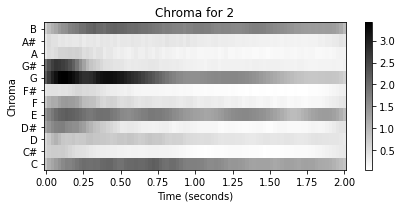

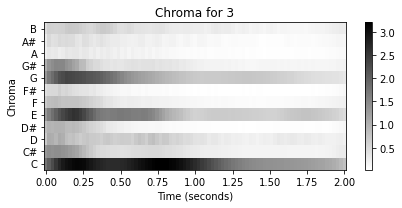

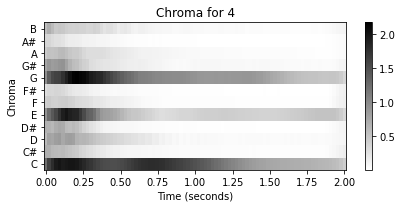

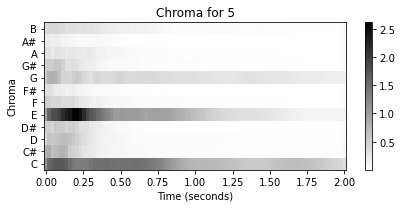

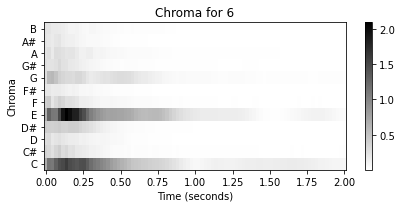

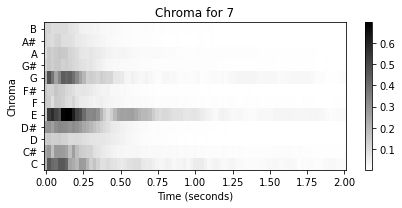

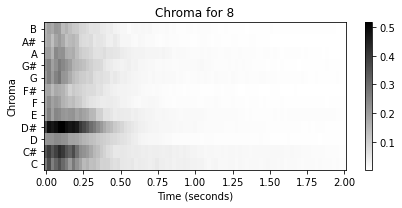

In [15]:
song_samples = [
    "/home/dofo/Repos/Github/neuromorphicsnn/chord_snn/dataset/chords/major_triad/D274_majortriad_C1_24.wav",
    "/home/dofo/Repos/Github/neuromorphicsnn/chord_snn/dataset/chords/major_triad/D274_majortriad_C2_36.wav",
    "/home/dofo/Repos/Github/neuromorphicsnn/chord_snn/dataset/chords/major_triad/D274_majortriad_C3_48.wav",
    "/home/dofo/Repos/Github/neuromorphicsnn/chord_snn/dataset/chords/major_triad/D274_majortriad_C4_60.wav",
    "/home/dofo/Repos/Github/neuromorphicsnn/chord_snn/dataset/chords/major_triad/D274_majortriad_C5_72.wav",
    "/home/dofo/Repos/Github/neuromorphicsnn/chord_snn/dataset/chords/major_triad/D274_majortriad_C6_84.wav",
    "/home/dofo/Repos/Github/neuromorphicsnn/chord_snn/dataset/chords/major_triad/D274_majortriad_C7_96.wav",
]

song_samples_2 = [
    "/home/dofo/Repos/Github/neuromorphicsnn/chord_snn/dataset/chords/major_triad/ES100_majortriad_C1_24.wav",
    "/home/dofo/Repos/Github/neuromorphicsnn/chord_snn/dataset/chords/major_triad/ES100_majortriad_C2_36.wav",
    "/home/dofo/Repos/Github/neuromorphicsnn/chord_snn/dataset/chords/major_triad/ES100_majortriad_C3_48.wav",
    "/home/dofo/Repos/Github/neuromorphicsnn/chord_snn/dataset/chords/major_triad/ES100_majortriad_C4_60.wav",
    "/home/dofo/Repos/Github/neuromorphicsnn/chord_snn/dataset/chords/major_triad/ES100_majortriad_C5_72.wav",
    "/home/dofo/Repos/Github/neuromorphicsnn/chord_snn/dataset/chords/major_triad/ES100_majortriad_C6_84.wav",
    "/home/dofo/Repos/Github/neuromorphicsnn/chord_snn/dataset/chords/major_triad/ES100_majortriad_C7_96.wav",
]

c_val = 2
for song in song_samples_2:
    chroma = Chromagram(song)
    
    plot_chromagram(chroma.chromagram, Fs=chroma.Fs_X, title=f"Chroma for {c_val}")
    c_val += 1
    
    c6 = "/home/dofo/Desktop/music/chords/major_triad/major_triad84.wav"

## Econder Class
This class gets the data from the chromogram and encodes it into a spike train. Use this and the chromogram class to create a dataset of spike trains. The parameter options are less flexible than that of the chromogram class. So you're gonna have to get in there and change the code itself. Sorry :/

In [9]:
class Encoder:
    
    def __init__(self, fn_wav):
        
        chromagram = Chromagram(fn_wav)                         # chromagram object for us to call on
        
        self.fn_wav = fn_wav                                    # filename of wav file
        self.num_frames = chromagram.num_frames                 # number of frames in chromagram, used to calculate interval      
        self.num_bins = chromagram.num_bins                     # number of bins in chromagram, used to calculate dmin and dmax
        self.time_steps = chromagram.time_steps                 # time steps in chromagram, used to calculate interval  amd subinterval_size
        
        self.chroma_as_list = self._get_chroma()                # chromagram as list
        
        self.encoder_params = {
            "dmin": self.num_bins * [0],                        # a list with the length of the number of bins
            "dmax": self.num_bins * [1],
            "encoders": [{ "rate": { "subinterval_size": self.time_steps } }], #if you change stuff, its this line that you're most likely looking for :)
            "interval": self.time_steps * self.num_frames,      # interval is the length of the song in ms
            }
        
        self.spikes = self._encode()                            # encoded chromagram
        
     
    def _get_chroma(self):
        chroma = Chromagram(self.fn_wav).chromagram             # chromagram as numpy array
        return chroma.tolist()

    def _encode(self):
        encoder = neuro.EncoderArray(self.encoder_params)       # encoder object. "neuro.EncoderArray" from framework
        spikes = encoder.get_timeseries_spikes(self.chroma_as_list) # encoded chromagram. "get_timeseries_spikes" from framework
        return spikes    

In [4]:
encoder_params = {
    "dmin": [-1],
    "dmax": [1.5],
    "encoders": [{ "rate": { "subinterval_size": 1 } }],
    "interval": 8.8,
    }

encoder = neuro.EncoderArray(encoder_params)

In [7]:
n_inputs = encoder.neurons

AttributeError: 'neuro.EncoderArray' object has no attribute 'neurons'

In [8]:
spikes = encoder.get_spikes([0.2])
spikes

In [10]:

risp_config = {
  "leak_mode": "all",
  "min_weight": -1,
  "max_weight": 1,
  "min_threshold": -1,
  "max_threshold": 1,
  "max_delay": 5,
  "discrete": False
}

proc = risp.Processor(risp_config)

net = neuro.Network()
net.set_properties(proc.get_network_properties())


In [131]:
n_inputs = 1
n_neurons = n_inputs
seed = 42

moa = neuro.MOA()
moa.seed(seed)
random.seed(seed)

In [132]:
def create_neuron(neuron_id, net, moa):
    neuron = net.add_node(neuron_id)
    net.randomize_node_properties(moa, neuron)
    return neuron

In [133]:
for i in range(n_inputs):
    neuron = create_neuron(i, net, moa)
    neuron.set("Threshold",0.75)
    net.add_input(neuron.id)



In [134]:
proc.load_network(net)

for i in range(net.num_nodes()):
    proc.track_neuron_events(i)

proc.apply_spikes(spikes)
proc.run(100)
v = proc.neuron_vectors()

In [135]:
v

[[0.0, 2.0, 4.0, 6.0, 8.0]]

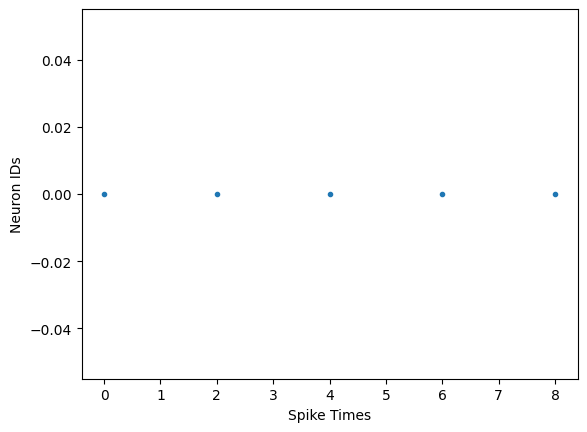

In [136]:

import matplotlib.pyplot as plt

plt.xlabel("Spike Times")
plt.ylabel("Neuron IDs")

for i in range(len(v)):
    plt.plot(v[i], [i]*len(v[i]), '.')

In [109]:
plot_chromagram(Chromagram("/home/dofo/Desktop/music/chords/major_triad/major_triad84.wav").chromagram, Fs=Chromagram("/home/dofo/Desktop/music/chords/major_triad/major_triad84.wav").Fs_X)

NameError: name 'plot_chromagram' is not defined

In [34]:

proc.clear_activity()